In [193]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [194]:
fashion_mnist = keras.datasets.fashion_mnist

In [195]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

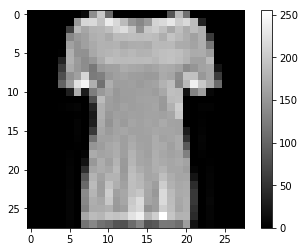

In [196]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [197]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

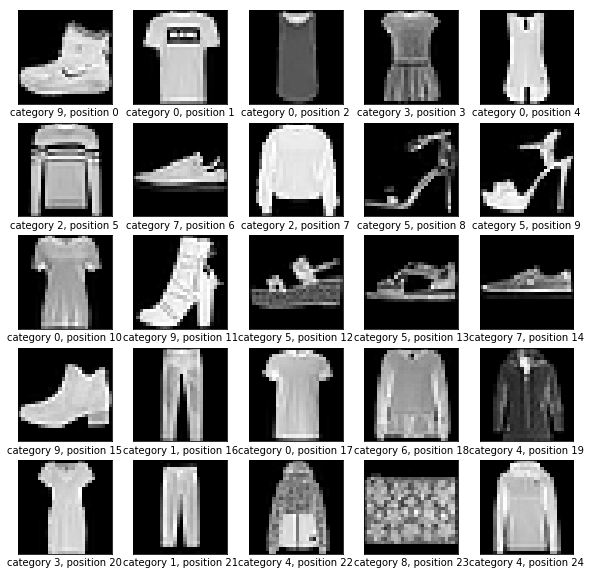

In [198]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel('category ' + str(train_labels[i]) + ', position ' + str(i))
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [199]:
tl_p = pd.DataFrame({'Category': train_labels[:]})
tl_p.index.name = 'index'
tl_p.describe()

,Category
count,60000.000000
mean,4.500000
std,2.872305
min,0.000000
25%,2.000000
50%,4.500000
75%,7.000000
max,9.000000


In [200]:
selection_train = (train_labels[:] == 6) | (train_labels[:] == 3) | (train_labels[:] == 9)
selection_train
train_labels_f = train_labels[selection_train]
train_labels_f.shape

(18000,)

In [201]:
train_images_f = train_images[selection_train]
train_images_f.shape

(18000, 28, 28)

In [202]:
train_images_reshape = np.reshape(train_images_f, (18000, 784))
train_images_reshape.shape

(18000, 784)

In [203]:
clothes_dict = {
    0: 'Dress',
    1: 'Shirt',
    2: 'Ankle boot'
}
selection_test = (test_labels[:] == 6) | (test_labels[:] == 3) | (test_labels[:] == 9)
selection_test
test_labels_f = test_labels[selection_test]
test_labels_f.shape

(3000,)

In [204]:
test_images_f = test_images[selection_test]
test_images_f.shape

(3000, 28, 28)

In [205]:
test_images_reshape = np.reshape(test_images_f, (3000, 784))
test_images_reshape.shape

(3000, 784)

In [206]:
test_images_reshape = test_images_reshape / 255
train_images_reshape = train_images_reshape / 255

In [207]:
one_hot_coding_uniq = np.unique(train_labels_f, return_inverse = 1)[1]
print(one_hot_coding_uniq)
one_hot_coding = (one_hot_coding_uniq.ravel()[:, None] == np.arange(one_hot_coding_uniq.max()+1)).astype(int)
one_hot_coding

[2 0 2 ... 1 1 0]


array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [208]:

# Tomar en cuenta el rango y dimensiones de los tensores
# Los datos de entrada x crudos son una matriz, pero el modelo lineal necesita un vector, hacer reshape a la forma adecuada
# cada pixel de la imagen pasa a ser una feature
x = tf.placeholder(tf.float32, [None, 784]) 
# para cada imagen(o el vector que la representa)  necesitamos como salida una dist. de probabilidad lo cual se traduce a un vector de tamaño "n" con n = al numero de posibles categorias
y_ = tf.placeholder(tf.float32, [None, 3]) 

# definir los parametros entrenables incluyendo el "bias" o w0,debe ser un tensor del tamaño adecuado: por cada feature tenemos "n" salidas con n = al numero de posibles categorias
# tip: W es una matriz
W = tf.Variable(tf.zeros([784, 3])) #
b = tf.Variable(tf.zeros([3])) #

y = tf.nn.softmax(tf.matmul(x, W) + b)

# el costo o loss es la entropia cruzada, agregar  a tensorboard con un summary.scalar
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy) 
tf.summary.scalar('cross_entropy',cross_entropy)

# el accuracy mide el porcentaje de observaciones que el modelo clasifica correctamente(comparando contra los datos reales ), agregarlo a tensorboard con summary.scalar
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy',accuracy)

# nos permite agrupar todos los summaries de nuestro grafo para facilitar calcular todos juntos.
summaries = tf.summary.merge_all()


# la ejecucion(sesion) hacerla con mini-batch gradient descent con un batch size = 32
# cada cierto numero de iteraciones "n" imprimir: el numero de iteracion, el loss de la iteracion, el accuracy de la iteracion y "enviarlo" a tensorboard


In [209]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batch_size = 32
    batchs = int(np.around(len(train_images_reshape) / batch_size))
    
    for i in range(5):
        i0 = 0
        i1 = batch_size - 1
        for batch in range(batchs):
            x_b = train_images_reshape[i0:i1]
            accuracy_, cross_entroy_, Y = sess.run([accuracy, train_step, y], feed_dict = {x: train_images_reshape, y_: one_hot_coding})
            
            if batch % 50 == 0:
                print('Epoch: ',i,' Batch: ',batch,' Accuracy: ',accuracy_,' output: ', Y)
            i0 = i0 + batch_size
            i1 = i1 + batch_size
      # Save the variables to disk.
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in path: %s" % save_path)

Epoch:  0  Batch:  0  Accuracy:  0.33333334  output:  [[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 ...
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]]
Epoch:  0  Batch:  50  Accuracy:  0.9333889  output:  [[0.01984321 0.05468265 0.92547417]
 [0.49341094 0.4445903  0.06199874]
 [0.1438288  0.3002556  0.5559156 ]
 ...
 [0.22061265 0.75305206 0.02633535]
 [0.12421351 0.81061345 0.06517301]
 [0.82715285 0.15259963 0.02024749]]
Epoch:  0  Batch:  100  Accuracy:  0.9368333  output:  [[0.00708568 0.02496315 0.96795124]
 [0.49916127 0.46583346 0.03500526]
 [0.10005952 0.26157334 0.6383672 ]
 ...
 [0.1338733  0.85684836 0.00927839]
 [0.06970801 0.9004277  0.02986433]
 [0.90765494 0.08537021 0.00697483]]
Epoch:  0  Batch:  150  Accuracy:  0.93916667  output:  [[0.00385744 0.01522408 0.98091847]
 [0.49224344 0.4830161  0.02474044]
 [0.07767177 0.23023729 0.69209087]
 ...
 [

Epoch:  2  Batch:  100  Accuracy:  0.953  output:  [[1.9252479e-04 1.0371745e-03 9.9877030e-01]
 [3.8032389e-01 6.1645126e-01 3.2248963e-03]
 [1.0778528e-02 5.5927295e-02 9.3329424e-01]
 ...
 [9.0573747e-03 9.9087989e-01 6.2674371e-05]
 [2.0632772e-02 9.7813225e-01 1.2349376e-03]
 [9.9081600e-01 9.0853609e-03 9.8650235e-05]]
Epoch:  2  Batch:  150  Accuracy:  0.95316666  output:  [[1.8108431e-04 9.8765350e-04 9.9883121e-01]
 [3.7918028e-01 6.1772907e-01 3.0907048e-03]
 [1.0203141e-02 5.3642329e-02 9.3615448e-01]
 ...
 [8.7268921e-03 9.9121583e-01 5.7330628e-05]
 [2.0460414e-02 9.7837436e-01 1.1653054e-03]
 [9.9106699e-01 8.8408217e-03 9.2158050e-05]]
Epoch:  2  Batch:  200  Accuracy:  0.95338887  output:  [[1.7063576e-04 9.4242243e-04 9.9888700e-01]
 [3.7819988e-01 6.1883324e-01 2.9668196e-03]
 [9.6703358e-03 5.1504884e-02 9.3882477e-01]
 ...
 [8.4245801e-03 9.9152279e-01 5.2619915e-05]
 [2.0291369e-02 9.7860706e-01 1.1015662e-03]
 [9.9130017e-01 8.6135790e-03 8.6322332e-05]]
Epoch:  2

Epoch:  4  Batch:  150  Accuracy:  0.9566111  output:  [[6.3475192e-05 4.6440397e-04 9.9947208e-01]
 [3.7805086e-01 6.2037909e-01 1.5700007e-03]
 [3.7675072e-03 2.5823237e-02 9.7040927e-01]
 ...
 [5.1520308e-03 9.9483407e-01 1.3872698e-05]
 [1.7297806e-02 9.8226446e-01 4.3779580e-04]
 [9.9417031e-01 5.7984600e-03 3.1298201e-05]]
Epoch:  4  Batch:  200  Accuracy:  0.95694447  output:  [[6.1180115e-05 4.5327158e-04 9.9948549e-01]
 [3.7852105e-01 6.1994368e-01 1.5352864e-03]
 [3.6317448e-03 2.5164304e-02 9.7120392e-01]
 ...
 [5.0719357e-03 9.9491477e-01 1.3237005e-05]
 [1.7187472e-02 9.8238927e-01 4.2325252e-04]
 [9.9425262e-01 5.7171159e-03 3.0197512e-05]]
Epoch:  4  Batch:  250  Accuracy:  0.957  output:  [[5.9002858e-05 4.4262569e-04 9.9949837e-01]
 [3.7900919e-01 6.1948884e-01 1.5019821e-03]
 [3.5025789e-03 2.4532514e-02 9.7196490e-01]
 ...
 [4.9950187e-03 9.9499232e-01 1.2641705e-05]
 [1.7079569e-02 9.8251098e-01 4.0943068e-04]
 [9.9433267e-01 5.6382064e-03 2.9154837e-05]]
Epoch:  4 

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


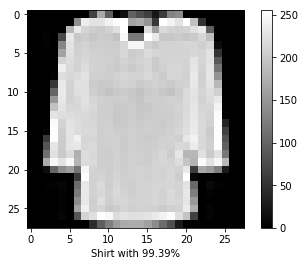

In [211]:
def predict_clothe(img_arr):
    copy_img = np.reshape(img_arr, (1, 784))
    copy_img = copy_img / 255
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, "/tmp/model.ckpt")
        accuracy_, cross_entroy_, Y = sess.run([accuracy, train_step, y], feed_dict = {x: copy_img, y_: one_hot_coding})
        category = np.argmax(Y)

        plt.figure()
        plt.imshow(img_arr, cmap = 'gray')
        plt.xlabel(clothes_dict[category] + ' with ' + str(round(np.max(Y) * 100,2)) + '%')
        plt.colorbar()
        
        
img = test_images_f[33]
predict_clothe(img)

sample positions
[ 951 2147  183    8 1607]
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


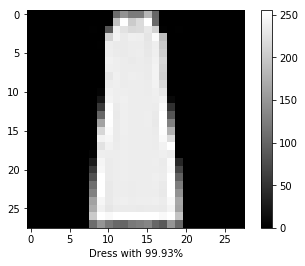

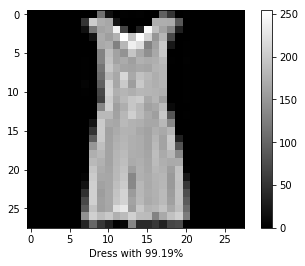

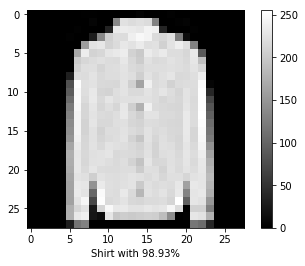

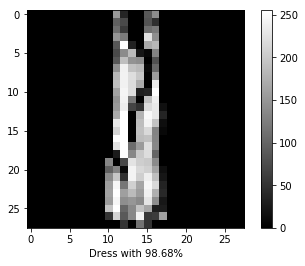

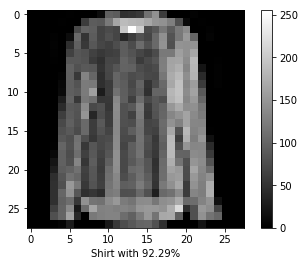

In [212]:
from random import randint
sample = np.random.randint(low=0, high=len(test_images_f), size=5)
print('sample positions')
print(sample)

for j in range(5):
    predict_clothe(test_images_f[sample[j]])